In [36]:
import os
import random
from  tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import torch.nn.init as init

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

from model import * #From model.py

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)


#transform = torchvision.transforms.ToTensor()
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model_avail = True
model_path = "../../../code/bestmodel_9.pth"
is_eval = True

def weight_init(m):
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)


In [37]:
#Load data return data loaders
def LoadData(image_folder, annotation_csv):
	train_labeled_scene_index = np.arange(106, 131)
	val_labeled_scene_index = np.arange(131, 132)
	labeled_trainset = LabeledDataset(image_folder=image_folder, annotation_file=annotation_csv, 
		scene_index=train_labeled_scene_index, transform=transform, extra_info=True)

	labeled_valset = LabeledDataset(image_folder=image_folder, annotation_file=annotation_csv,
		scene_index=val_labeled_scene_index,transform=transform,extra_info=True)

	trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
	valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

	return trainloader, valloader

In [38]:
#ThreatScore Per Sample - Determines Model Performance - Challenge Metric
def ThreatScore(true, pred):
    tp = (true * pred).sum()
    return (tp * 1.0 / (true.sum() + pred.sum() - tp)).item()

#ThreatScore Per Batch- Determines Model Performance - Challenge Metric
def BatchThreatScore(true, pred):
    batch_size = true.size(0)
    true = true.reshape(batch_size, -1)
    pred = pred.reshape(batch_size, -1)
    tp = (true * pred).sum(1)
    return (tp * 1.0 / (true.sum(1) + pred.sum(1) - tp)).sum().item()

def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [39]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder_features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=(2,3)),
            nn.ReLU(inplace=True),
            #Current Size:- 64 x 256 x 308
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Current Size:- 64 x 128 x 154
            nn.Conv2d(64, 192, kernel_size=3, padding=(1,2)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),
            #Current Size:- 192 x 128 x 156
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Current Size:- 384 x 128 x 156
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            #Current Size:- 256 x 128 x 156
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Current Size:- 256 x 64 x 78
            nn.Conv2d(256, 192, kernel_size=(3,5), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),
            #Current Size:- 192 x 64 x 76
            nn.Conv2d(192, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Current Size:- 64 x 64 x 76
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Current Size:- 64 x 64 x 76
        )
        
    def forward(self,x):
        return self.encoder_features(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder_features = nn.Sequential(
        	nn.Upsample(size=(100,100), mode='bilinear', align_corners=True),
        	#Current Size:- 384 x 100 x 100
        	nn.ConvTranspose2d(384, 256, kernel_size=4, stride=2, padding=1),
        	nn.ReLU(inplace=True),
                nn.BatchNorm2d(256),
        	#Current Size:- 256 x 200 x 200
        	nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        	#Current Size:- 192 x 200 x 200
        	nn.ConvTranspose2d(192, 64, kernel_size=4, stride=2, padding=1),
        	nn.ReLU(inplace=True),
                nn.BatchNorm2d(64),
        	#Current Size:- 64 x 400 x 400
        	nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Current Size:- 32 x 400 x 400
        	nn.ConvTranspose2d(32, 1,kernel_size=4, stride=2, padding=1),
        	nn.ReLU(inplace=True),
        	#Current Size:- 1 x 800 x 800
        )
        
    def forward(self,x):
        return self.decoder_features(x)


class Encoder_Decoder(nn.Module):
    def __init__(self):
        super(Encoder_Decoder, self).__init__()
        #Input Size:- 3 x 256 x 306
        self.encoders = nn.ModuleList()
        for _ in range(6):
            self.encoders.append(Encoder())
        self.decoder = Decoder()

    def forward(self, x):
        x = x.permute(1,0,2,3,4)
        x = x-0.5
        encoder_outs = []
        for i in range(6):
            encoder_outs.append(self.encoders[i](x[i]))
        encoder_output = torch.stack(encoder_outs).permute(0,2,1,3,4)
        encoder_output = torch.cat([i for i in encoder_output]).permute(1,0,2,3)
        decoder_output = self.decoder(encoder_output)
        return decoder_output

def evaluate(model, valloader):
    model.eval()
    ts = 0
    loss = 0
    with torch.no_grad():
        for data in valloader:
            sample, target, road_image, extra  = data
            road_image_true = torch.stack([torch.Tensor(x.numpy()) for x in road_image]).to(device)
            outputs = model(torch.stack(sample).to(device))
            outputs = outputs.float()
            loss += dice_loss(road_image_true, outputs)
            outputs = torch.squeeze(outputs,dim=1)
            outputs = (outputs >= 0.5).float()
            ts += BatchThreatScore(road_image_true, outputs)

    return loss/(8*len(valloader)), ts/(len(valloader)*8)

  0%|          | 0/1 [00:00<?, ?it/s]

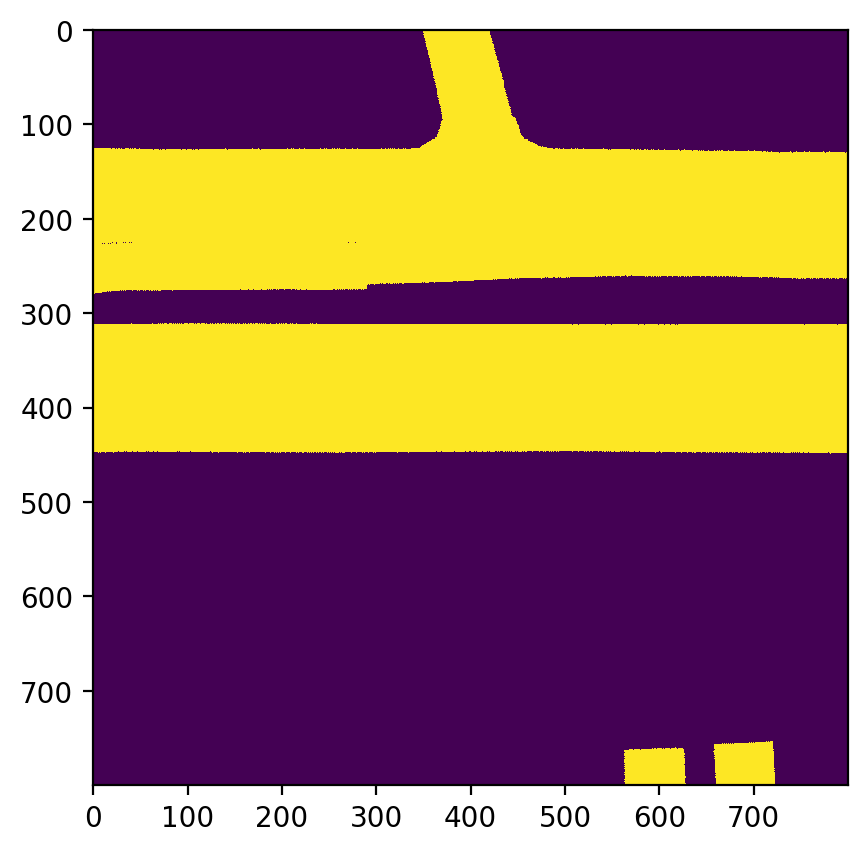

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.) tensor(1.)


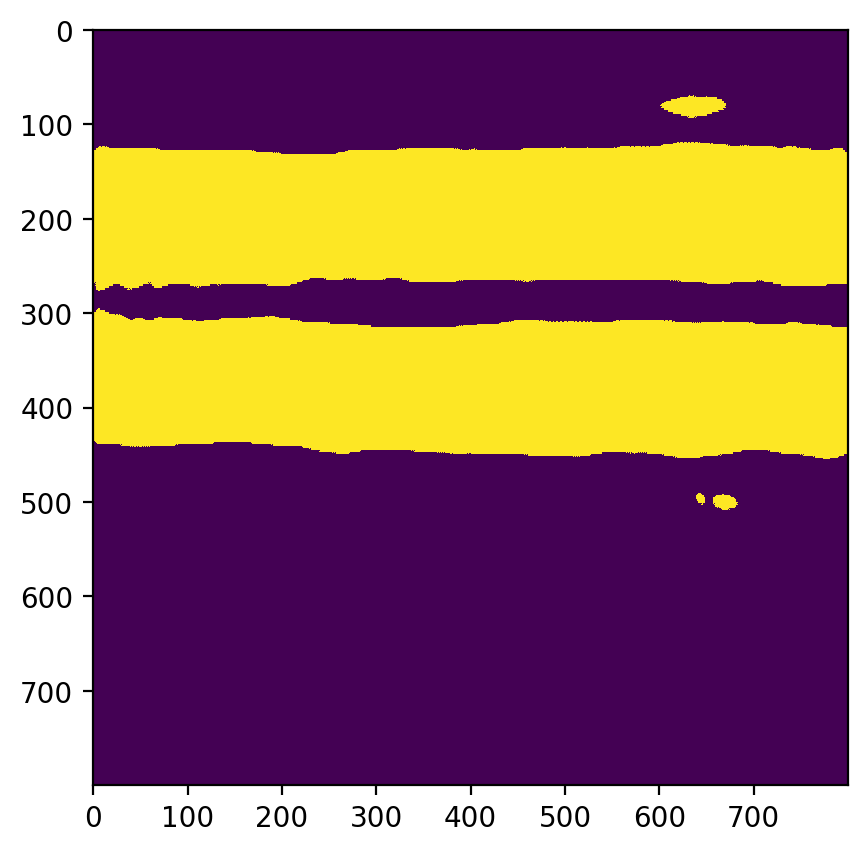

0.8711147308349609
Random TS: 
0.2591855227947235


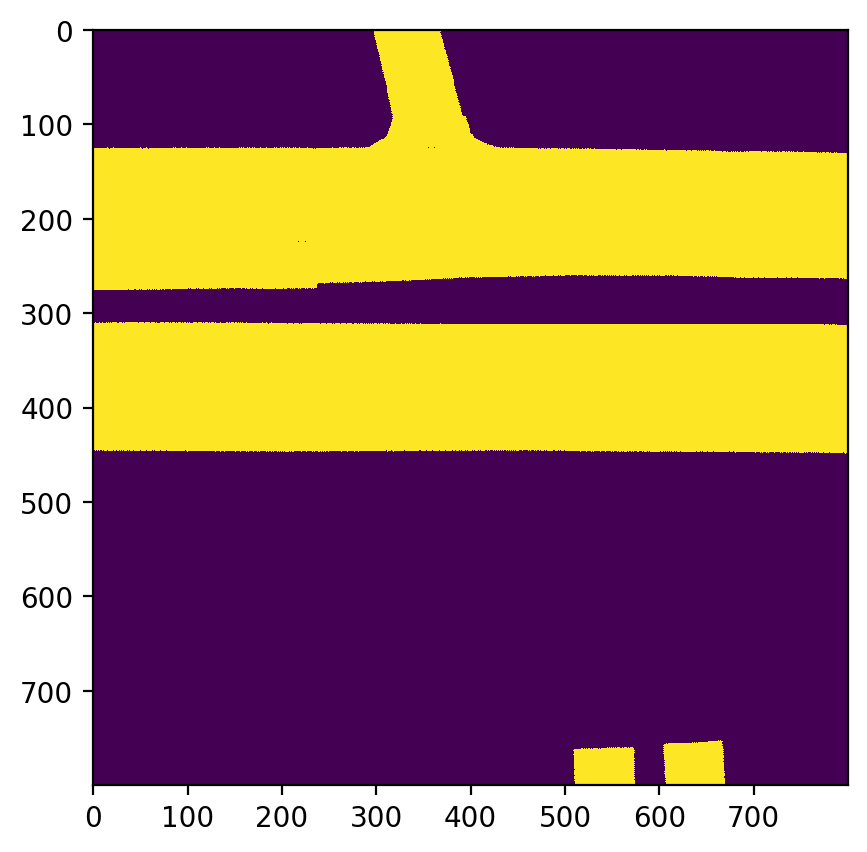

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.) tensor(1.)


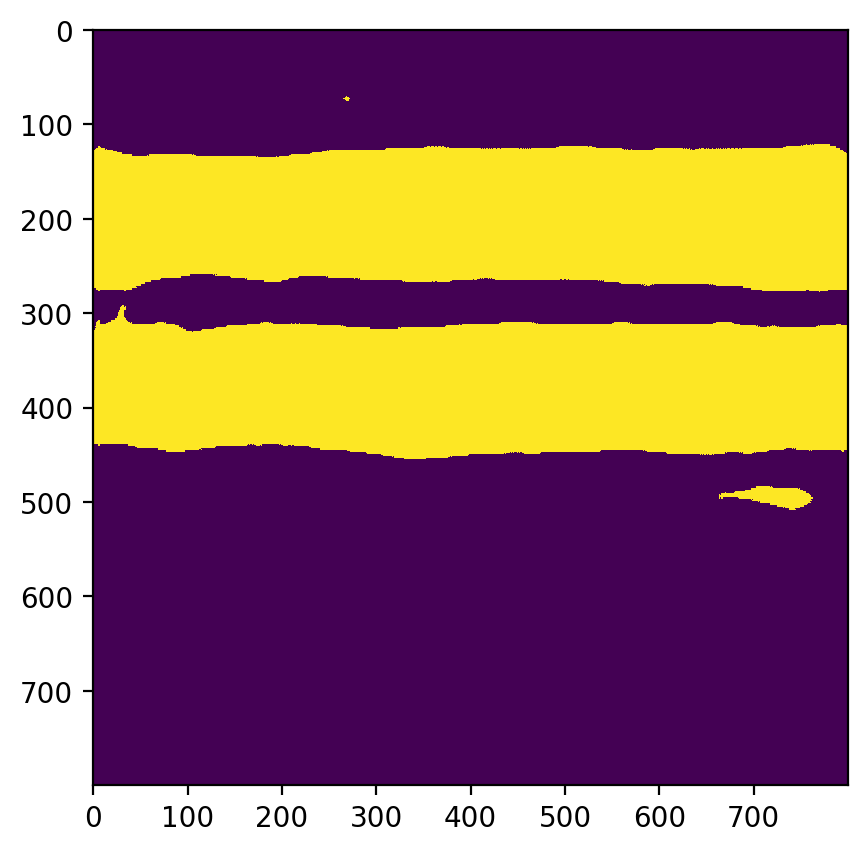

0.8789470195770264
Random TS: 
0.25812432169914246


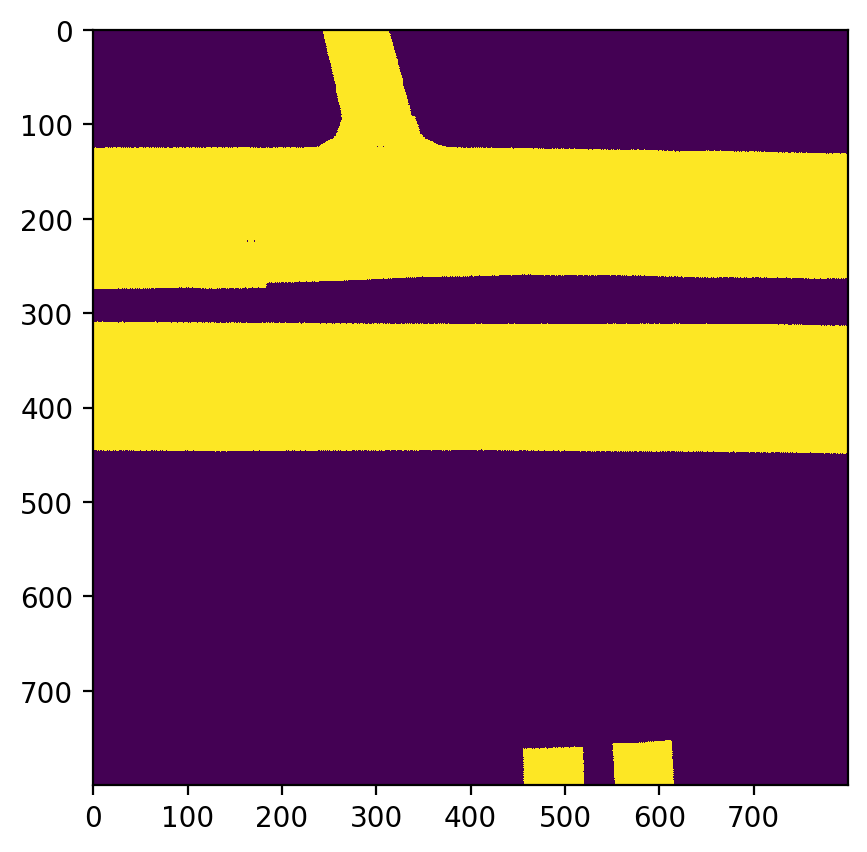

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.) tensor(1.)


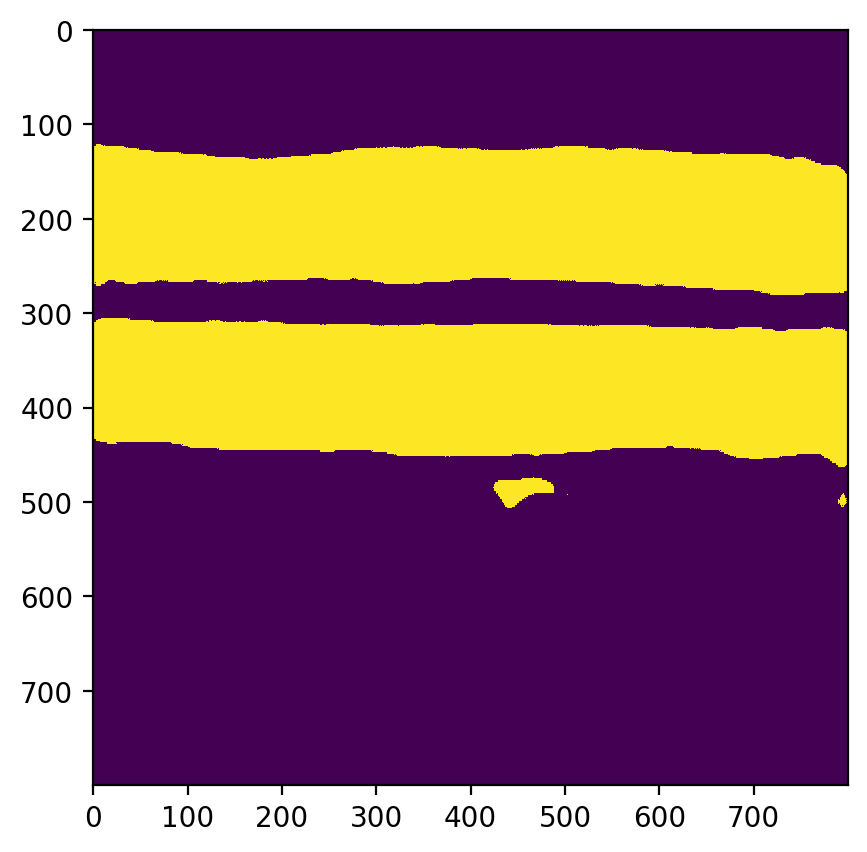

0.8790692687034607
Random TS: 
0.2549455463886261


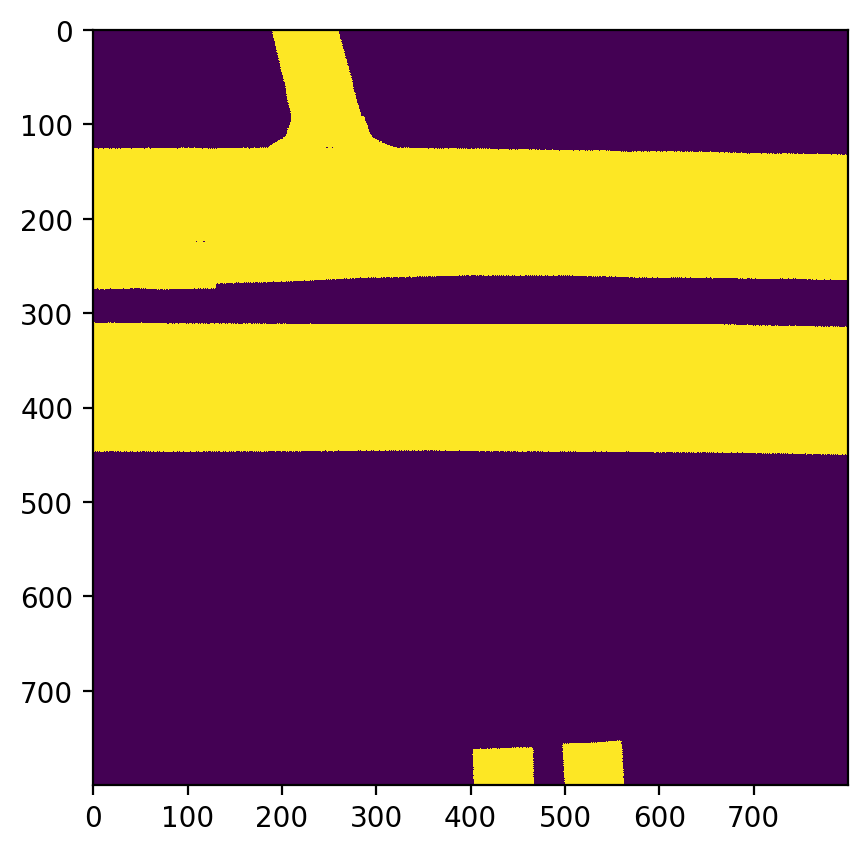

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.) tensor(1.)


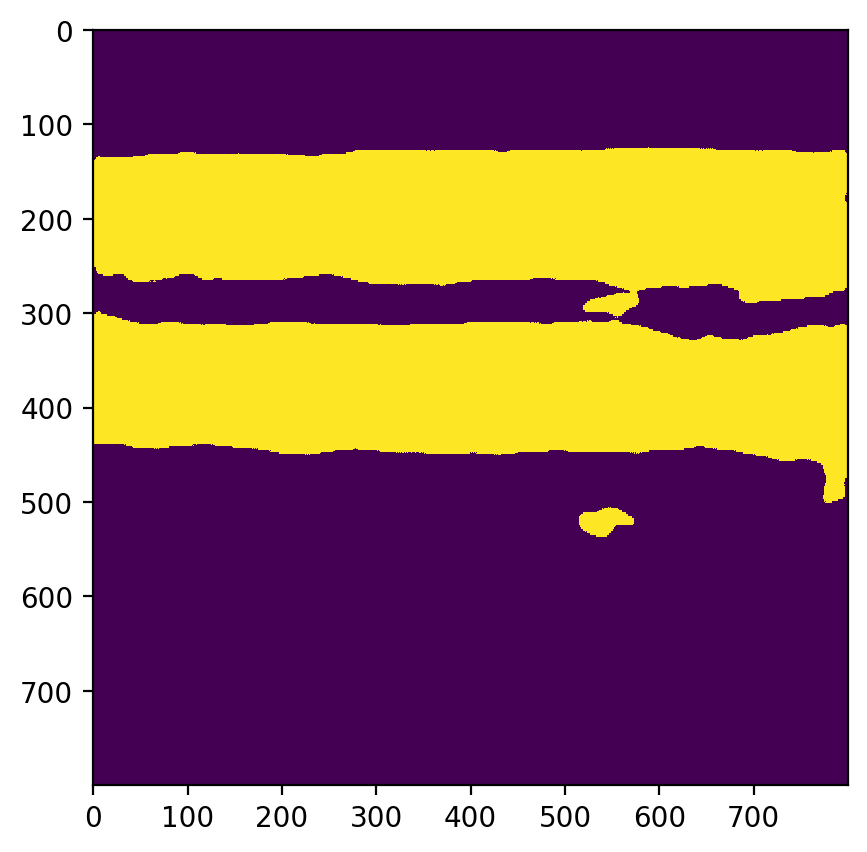

0.8747175335884094
Random TS: 
0.25459760427474976


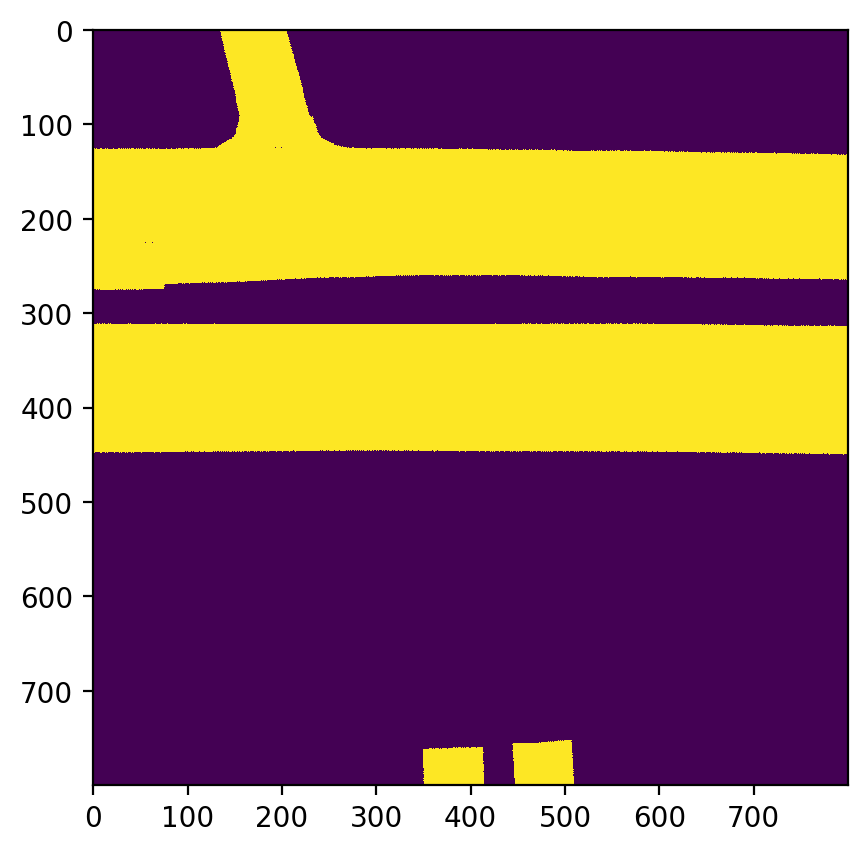

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.) tensor(1.)


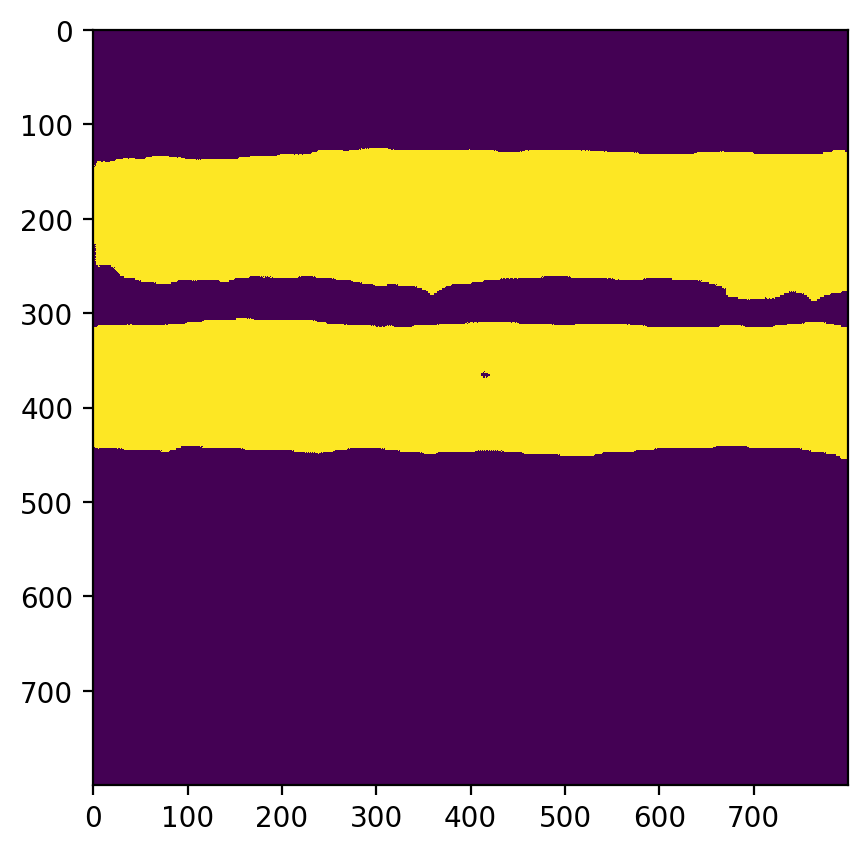

0.8697258234024048
Random TS: 
0.2523198127746582


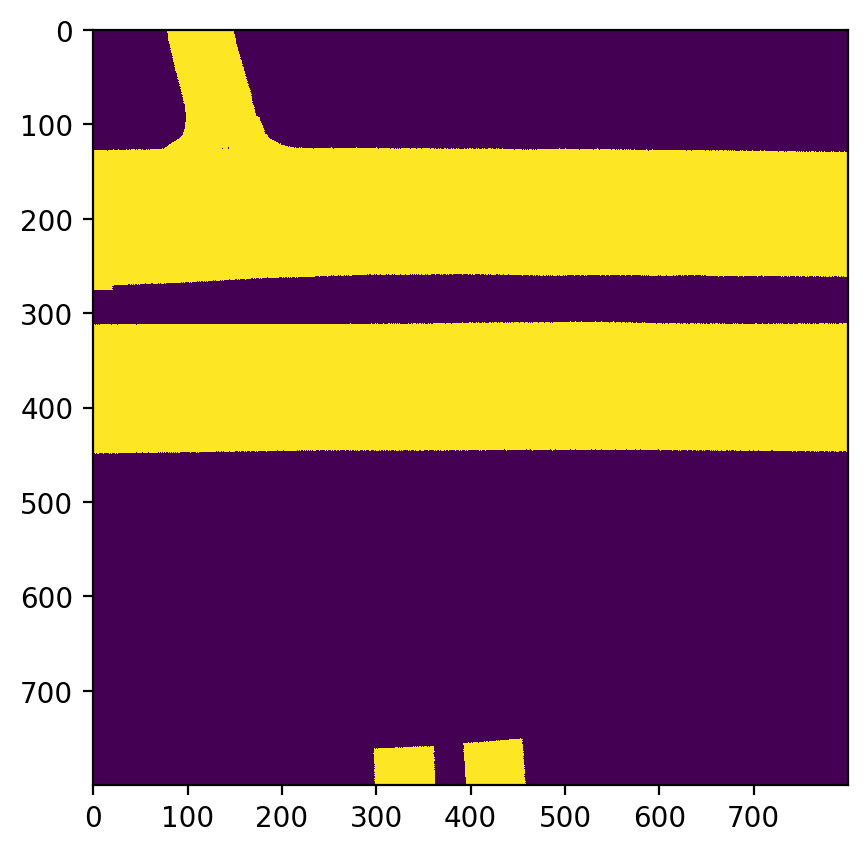

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.) tensor(1.)


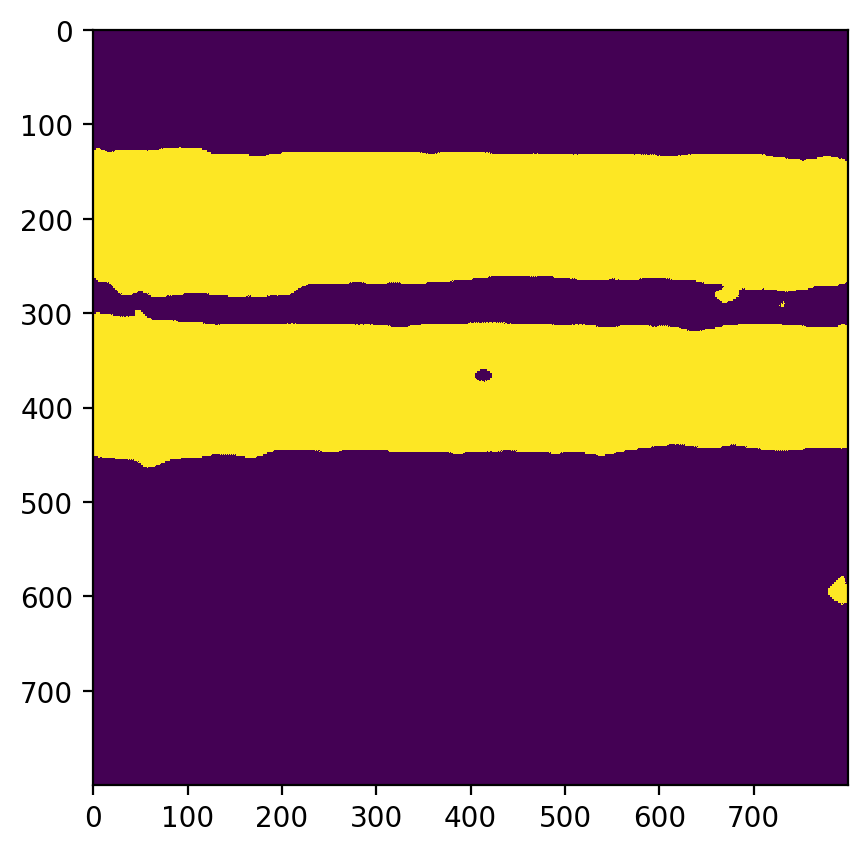

0.8545231223106384
Random TS: 
0.25760769844055176


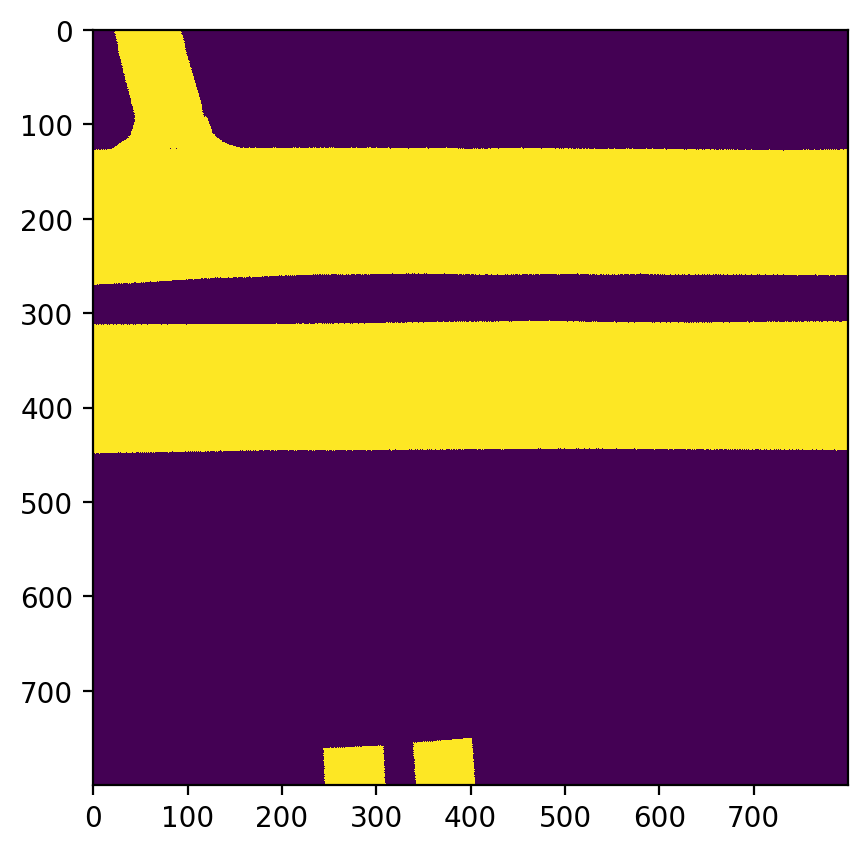

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(0.) tensor(1.)


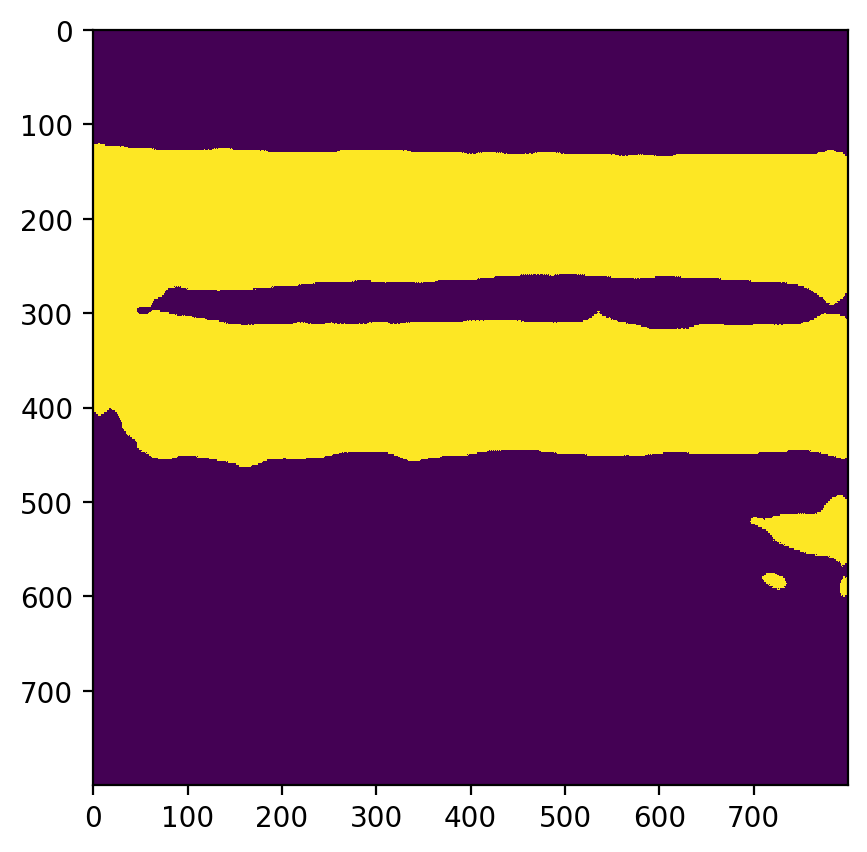

0.872702956199646
Random TS: 
0.25838741660118103


Exception ignored in: <function _DataLoaderIter.__del__ at 0x120109cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
  0%|          | 0/1 [01:01<?, ?it/s]


KeyboardInterrupt: 

In [40]:
def main():
    
    image_folder = '../../../data'
    annotation_csv = '../../../data/annotation.csv'
    trainloader, valloader = LoadData(image_folder, annotation_csv)
    sample, target, road_image, extra = iter(trainloader).next()
    #print(road_image)
    #device = "cpu"
    model = UNet_Encoder_Vanilla_Decoder()
    model.to(device)
    if model_avail:
        model.load_state_dict(torch.load(model_path,map_location=lambda storage, location: storage))
    else:
        model.apply(weight_init)
    #print (evaluate(model,valloader))
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    if is_eval:
        model.eval()
        num_epochs = 1
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            data_len = len(valloader)
            for i, data in enumerate(valloader, 0):
                sample, target, road_image, extra  = data
                outputs = model(torch.stack(sample).to(device))
                outputs = torch.squeeze(outputs, dim=1)
                road_image_true = torch.stack([torch.Tensor(x.numpy()) for x in road_image]).to(device)
                plt.imshow(road_image_true[0].numpy())
                plt.show()
                #loss = criterion(outputs, road_image_true) + 10*criterion(outputs*road_image_true, road_image_true)
                #outputs.clamp(0,1)
                #_, predicted = torch.max(outputs.data, 0)
                #outputs = predicted
                outputs = outputs>=0.3
                outputs = outputs.float()
                print(outputs[0])
                print(road_image_true[0])
                print(outputs[0].min(), outputs[0].max())
                plt.imshow(outputs[1].detach().numpy())
                plt.show()
                print(ThreatScore(road_image_true[0],outputs[0]))
                print("Random TS: "),
                random_map = torch.randint(0,2,(800,800)).float()
                print(ThreatScore(random_map,outputs[0]))
    else:
        
        num_epochs = 150
        model.train()

        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            data_len = len(trainloader)
            for i, data in enumerate(trainloader, 0):
                sample, target, road_image, extra  = data
                optimizer.zero_grad()
                outputs = model(torch.stack(sample).to(device))
                outputs = torch.squeeze(outputs)
                road_image_true = torch.stack([torch.Tensor(x.numpy()) for x in road_image]).to(device)
                loss = criterion(outputs, road_image_true) + 10*criterion(outputs*road_image_true, road_image_true)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            print('[%d, %5d] loss: %.3f' % (epoch + 1, num_epochs, running_loss / data_len))
            torch.save(model.state_dict(), 'model_'+str(epoch)+'.pth')
    
if __name__ == '__main__':
	main()


In [ ]:
# Put your transform function here, we will use it for our dataloader
def get_transform(): 
    # return torchvision.transforms.Compose([
    # 
    # 
    # ])
    #transform = torchvision.transforms.ToTensor()
    return torchvision.transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

class ModelLoader():
    # Fill the information for your team
    team_name = 'Connectionists'
    team_member = ["Mohith Damarapati", "Vikas Patidar", "Alfred Ajay Aureate Rajakumar"]
    contact_email = 'md4289@nyu.edu'

    def __init__(model_file):
        # You should 
        #       1. create the model object
        #       2. load your state_dict
        #       3. call cuda()
        # self.model = ...
        # 
        self.roadmap_model = Resnet_Encoder_Decoder()
        self.objdet_model = Resnet_Encoder_Decoder()
        checkpoint = torch.load(model_file)

        self.roadmap_model.load_state_dict(checkpoint['roadmap'])
        self.objdet_model.load_state_dict(checkpoint['objdet'])

        self.roadmap_model.cuda()
        self.objdet_model.cuda()

    def get_bounding_boxes_util(object_map, th=0.5):
        object_map = object_map.squeeze(dim=1)
        object_map = (object_map >= th).float()
        _, contours, _ = cv2.findContours((object_map.detach().numpy()).astype(np.uint8),cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        boxes = []

        for c in cnts:
            rect = cv2.boundingRect(c)
            x,y,w,h = rect
            if w*h < 200:
                continue
            pointsx = [x, x+w, x, x+w]
            pointsy = [y, y, y+h, y+h]
            pointsx = map(lambda a: (a-400)*1.0/10, pointsx)
            pointsy = map(lambda a: (a-400)*1.0/10, pointsy)
            x_tensor  = torch.tensor(pointsx, dtype = torch.float32)
            y_tensor = torch.tensor(pointsy, dtype = torch.float32)
            box = torch.stack((x_tensor,y_tensor))
            boxes.append(box)

        outputs = torch.stack(boxes)
        return outputs

    def get_bounding_boxes(samples):
        # samples is a cuda tensor with size [batch_size, 6, 3, 256, 306]
        # You need to return a tuple with size 'batch_size' and each element is a cuda tensor [N, 2, 4]
        # where N is the number of object
        object_map = self.objdet_model(samples)
        return get_bounding_boxes_util(object_map, 0.5)

    def get_binary_road_map(samples):
        # samples is a cuda tensor with size [batch_size, 6, 3, 256, 306]
        # You need to return a cuda tensor with size [batch_size, 800, 800] 
        
        return (self.roadmap_model(samples) >= 0.5).float()